In [61]:
import os
import numpy as np
import pystan
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
import corner

In [34]:
data=Table.read('LQSO_CASTLE.csv',format='csv')

In [35]:
allwise=Table.read('QSO_ALLWISE_CLEANED.csv', format='csv')

In [36]:
data = data.to_pandas()
data = data[np.isfinite(data['pmra'])]
allwise = allwise.to_pandas()
allwise = allwise[np.isfinite(allwise['pmra'])]

In [37]:
def sigma2(ea,ed,c) : 
    """ the largest eigen value of the covariance matrix defined by
    ea : right ascention error
    ed : declination error
    c  : correlation
    """
    res = np.power(ea,2) + np.power(ed,2) 
    res = res + np.sqrt(np.power(ea-ed,2) + np.power(2*ea*ed*c,2))
    return res/2

def setMu(d):
    """
    set mu, mu_error and mu_norm taking in account the correlation
    """
    d['mu'] = np.sqrt(np.power(d.pmra,2)+np.power(d.pmdec,2))
    d['mu_error'] = np.sqrt(sigma2(d.pmra_error,d.pmdec_error,d.pmra_pmdec_corr))
    d['mu_over_error'] = d.mu/d.mu_error

In [38]:
setMu(data)
setMu(allwise)

In [45]:
Nl = len(data)
Nq = len(allwise)

In [39]:
bayesodds2 = """
data{
    int<lower=0> Nq; //number of quasars
    int<lower=0> Nl; //number of lens
    vector[Nq] muqhat; //propermotion of qso
    vector[Nl] mulhat; //propermotion of lens
    vector<lower=0>[Nq] sigq; //error on pm of qso
    vector<lower=0>[Nl] sigl; //error on pm of lens
}

parameters{
//population parameters
    real mu1;
    real mu2;   
    real<lower=0> sigma1;
    real<lower=0> sigma2;
    vector<lower=0>[Nq] muq; //propermotion of qso
    vector<lower=0>[Nl] mul; //propermotion of lens
}

model{

    mu1 ~ normal(0,1); 
    mu2 ~ normal(0,1); 
    sigma1 ~ normal(0,1);
    sigma2 ~ normal(0,1);

    muqhat ~ normal(muq, sigq);  
    mulhat ~ normal(mul, sigl);  

    muq ~ lognormal(mu1, sigma1);
    mul ~ lognormal(mu2, sigma2);
}


"""

In [48]:
qsodat = {
    'Nq': Nq,
    'Nl': Nl,
    'muqhat': allwise.mu,
    'mulhat': data.mu,
    'sigq': allwise.mu_error,
    'sigl': data.mu_error
}

In [49]:
sm = pystan.StanModel(model_code=bayesodds2)
fit = sm.sampling(data=qsodat, iter=1000, chains=1) # Could be run for longer, but 1 chain at 1000 samples takes ~4hrs

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46d4033018b8c1e4c0d1317fde48de2b NOW.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [51]:
params=fit.extract()

In [54]:
mu1=params['mu1']
mu2=params['mu2']
sigma1=params['sigma1']
sigma2=params['sigma2']

In [55]:
np.mean(mu1)

-0.6088631224931288

In [57]:
np.mean(mu2)

-0.35553950229517445

In [88]:
pop_params = np.vstack([mu1,mu2,sigma1,sigma2])


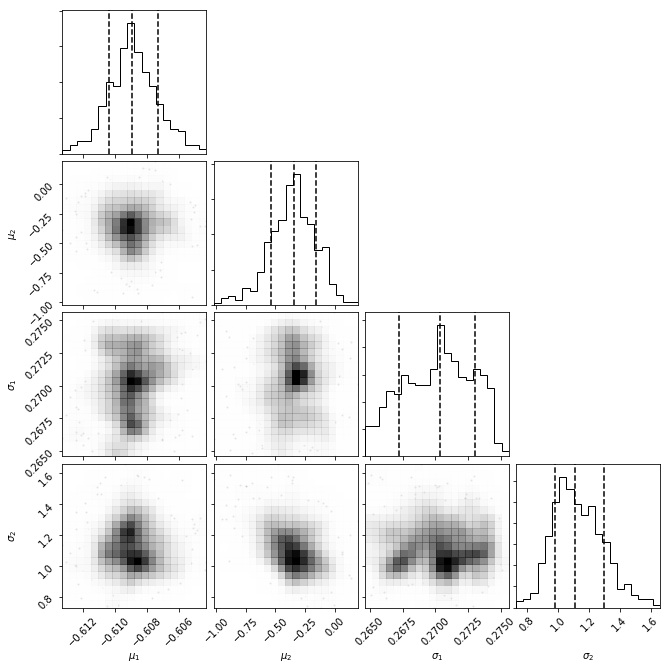

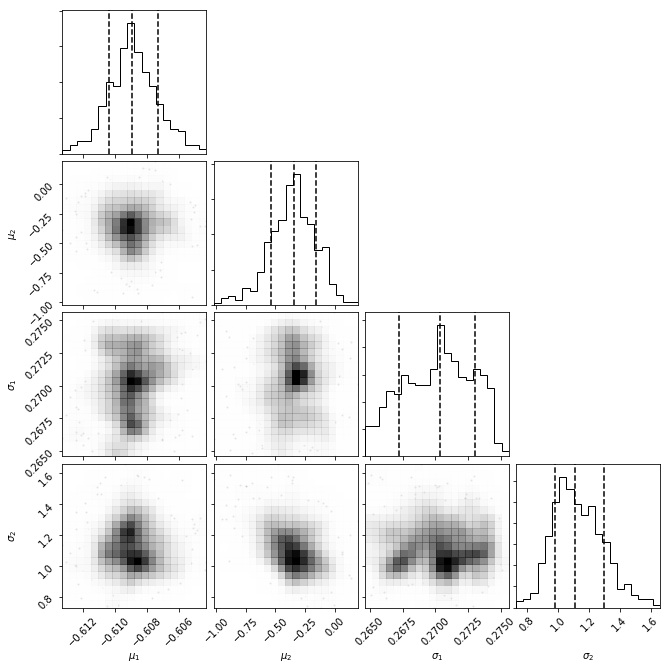

In [92]:
corner.corner(pop_params.T, 
                labels=[r"$\mu_1$", r"$\mu_2$", r"$\sigma_1$", r"$\sigma_2$"],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)